In [194]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
import time

import warnings
warnings.filterwarnings("ignore")

In [195]:
pd.set_option('display.max_rows', None)

In [196]:
melb_df = pd.read_csv('melb_data.csv')
melb_df.info()
melb_df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
Suburb           13580 non-null object
Address          13580 non-null object
Rooms            13580 non-null int64
Type             13580 non-null object
Price            13580 non-null float64
Method           13580 non-null object
SellerG          13580 non-null object
Date             13580 non-null object
Distance         13580 non-null float64
Postcode         13580 non-null float64
Bedroom2         13580 non-null float64
Bathroom         13580 non-null float64
Car              13518 non-null float64
Landsize         13580 non-null float64
BuildingArea     7130 non-null float64
YearBuilt        8205 non-null float64
CouncilArea      12211 non-null object
Lattitude        13580 non-null float64
Longtitude       13580 non-null float64
Regionname       13580 non-null object
Propertycount    13580 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 2.2+ MB


BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Car                62
Propertycount       0
Date                0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Bedroom2            0
Distance            0
Postcode            0
Regionname          0
Bathroom            0
Landsize            0
Lattitude           0
Longtitude          0
Suburb              0
dtype: int64

## clean

In [197]:
melb_df = melb_df.drop(['BuildingArea','YearBuilt','CouncilArea'], axis=1)

In [198]:
melb_df = melb_df.dropna()

In [199]:
melb_df.isnull().sum().sort_values(ascending=False)

Propertycount    0
Regionname       0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
Lattitude        0
Longtitude       0
Suburb           0
dtype: int64

## Encoding qualitative data

In [201]:
from sklearn.preprocessing import LabelEncoder

melb_df[['Suburb','Type','Regionname','SellerG','Method']] =  melb_df[['Suburb','Type','Regionname','SellerG','Method']].apply(LabelEncoder().fit_transform)

## to datetime

In [202]:
melb_df['Date'] = pd.to_datetime(melb_df['Date'])
melb_df['Date'].describe()

count                   13518
unique                     58
top       2017-05-27 00:00:00
freq                      473
first     2016-01-28 00:00:00
last      2017-12-08 00:00:00
Name: Date, dtype: object

## Datetime to interger

In [203]:
def convert_to_timestamp(x):
    ##Convert date objects to integers
    return time.mktime(x.timetuple())

In [204]:
melb_df['Date'] = melb_df['Date'].apply(convert_to_timestamp)

## Normalization date

In [205]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

melb_df['Date'] = scaler.fit_transform(melb_df['Date'].values.reshape(-1,1))

In [206]:
melb_df['Date'].describe()

count    13518.000000
mean         0.522873
std          0.263867
min          0.000000
25%          0.286826
50%          0.579412
75%          0.754473
max          1.000000
Name: Date, dtype: float64

## columns,traget (X,Y)

In [260]:
columns = melb_df.columns.tolist()
columns = [c for c in columns if c not in ['Price','Address','Bedroom2','Lattitude','Longtitude','Propertycount','Postcode']]
target = 'Price'

In [261]:
melb_df[columns].head()


,Suburb,Rooms,Type,Method,SellerG,Date,Distance,Bathroom,Car,Landsize,Regionname
0,0,2,0,1,23,0.064706,2.5,1.0,1.0,202.0,2
1,0,2,0,1,23,0.095588,2.5,1.0,0.0,156.0,2
2,0,3,0,3,23,0.633885,2.5,2.0,0.0,134.0,2
3,0,3,0,0,23,0.633885,2.5,2.0,1.0,94.0,2
4,0,4,0,4,155,0.101532,2.5,1.0,2.0,120.0,2


In [262]:
melb_df[target].head()

0    1480000.0
1    1035000.0
2    1465000.0
3     850000.0
4    1600000.0
Name: Price, dtype: float64

In [263]:
from sklearn.feature_selection import SelectKBest,f_regression
bestfeatures = SelectKBest(score_func = f_regression,k = 10)
fit = bestfeatures.fit(melb_df[columns], melb_df[target])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(melb_df[columns].columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(10,'Score'))

         Specs        Score
1        Rooms  4449.308517
7     Bathroom  3784.740833
2         Type  2802.436217
8          Car   818.668785
6     Distance   360.044231
0       Suburb   252.157347
10  Regionname    85.284830
4      SellerG    37.399810
3       Method    19.549474
9     Landsize    19.015117


In [264]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(melb_df[columns], melb_df[target], test_size=0.3, random_state=0)

In [265]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, melb_df[columns], melb_df[target], cv=5, scoring='r2')
    return pred

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [266]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [267]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [268]:
print(lin_reg.intercept_)

1074909.6457408583


In [269]:
coeff_df = pd.DataFrame(lin_reg.coef_, columns, columns=['Coefficient'])
coeff_df

,Coefficient
Suburb,-63855.284489
Rooms,165360.977143
Type,-173194.024058
Method,-12238.578490
SellerG,-14367.917476
Date,28424.324879
Distance,-235334.571970
Bathroom,177721.894847
Car,39979.547764
Landsize,14213.647601


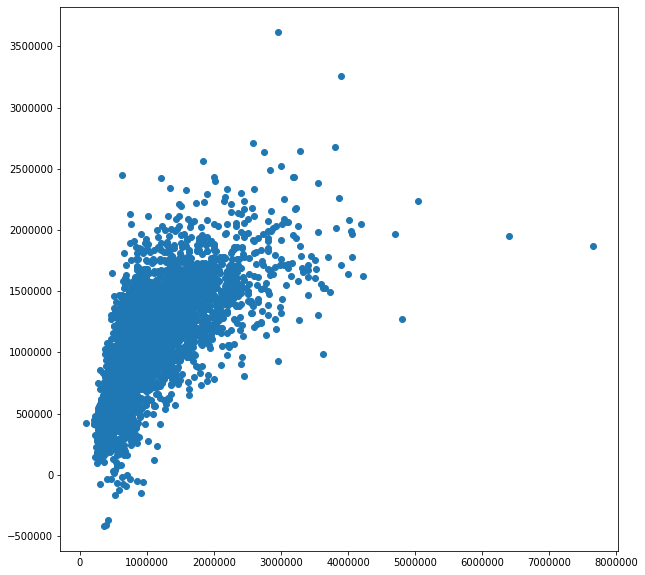

In [270]:
pred = lin_reg.predict(X_test)
figure, axis = plt.subplots(figsize=(10, 10))
plt.scatter(y_test, pred)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.ticklabel_format(useOffset=False, style='plain', axis='x')

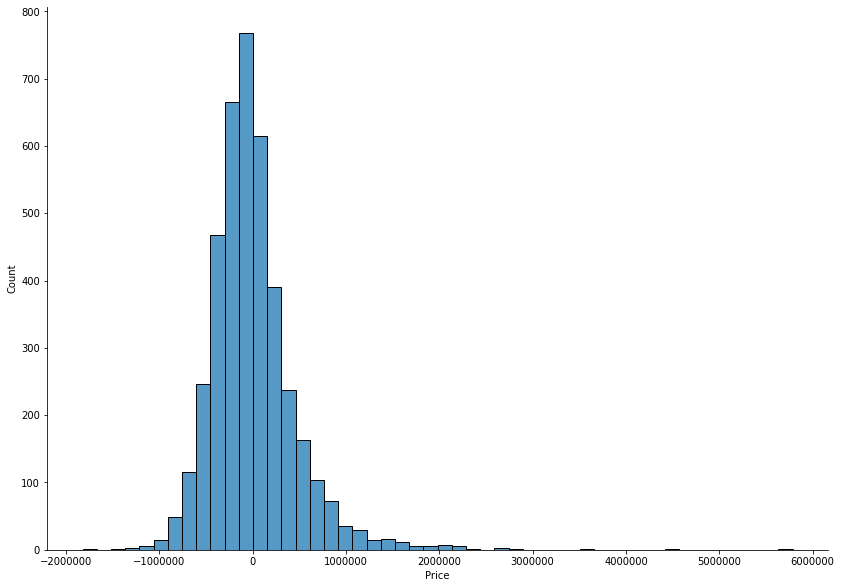

In [271]:

sns.displot((y_test - pred), bins=50,height=8.27, aspect=11.7/8.27)

plt.ticklabel_format(useOffset=False, style='plain', axis='x')

In [272]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 319250.75553433126
MSE: 208386657571.59943
RMSE: 456493.8746265928
R2 Square 0.45800726297960204
Train set evaluation:
_____________________________________
MAE: 322228.73164274957
MSE: 225383274525.37018
RMSE: 474745.4839441553
R2 Square 0.4634562358172122


In [273]:
evaluate_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
evaluate_df



,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,319250.755534,2.083867e+11,456493.874627,0.458007,"[0.5106412114031609, 0.4815949371512378, 0.472..."


In [274]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=4)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d,y_train)

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 1542854.6191175112
MSE: 3451954776839290.5
RMSE: 58753338.43143971
R2 Square -8977.18718037133
Train set evaluation:
_____________________________________
MAE: 187287.7491256143
MSE: 83017085477.52089
RMSE: 288126.85657106125
R2 Square 0.8023708741147986


In [275]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 184037.76924696748
MSE: 89323742378.6606
RMSE: 298870.7787299732
R2 Square 0.7676779301665173
Train set evaluation:
_____________________________________
MAE: 68566.89783035652
MSE: 13982205059.200535
RMSE: 118246.37440192631
R2 Square 0.9667141896405689


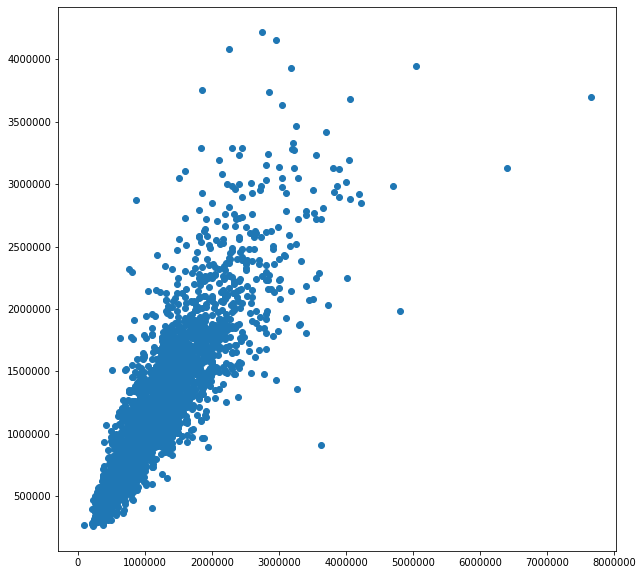

In [276]:
pred = rf_reg.predict(X_test)
figure, axis = plt.subplots(figsize=(10, 10))
plt.scatter(y_test, pred)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.ticklabel_format(useOffset=False, style='plain', axis='x')

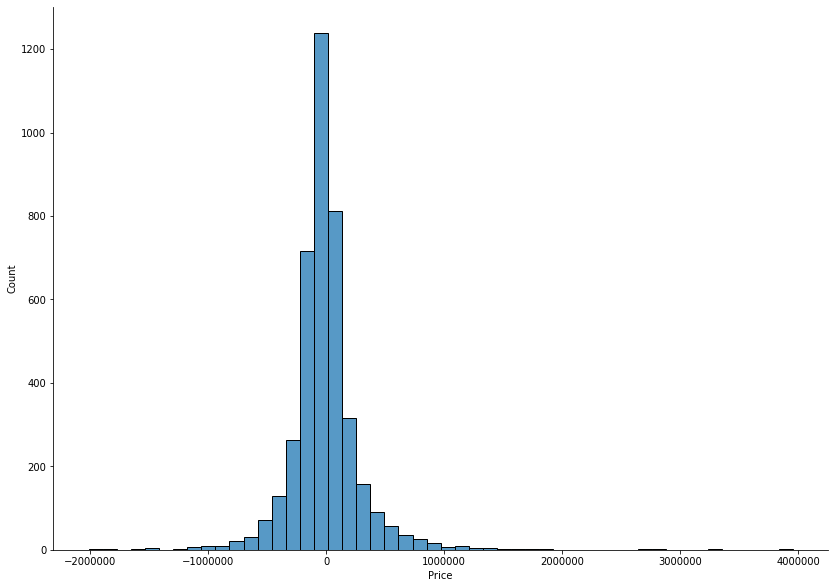

In [277]:
sns.displot((y_test - pred), bins=50,height=8.27, aspect=11.7/8.27)

plt.ticklabel_format(useOffset=False, style='plain', axis='x')